In [2]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from copy import deepcopy
from sklearn.model_selection import cross_val_score
import xgboost
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf
from tensorflow import keras

In [4]:
def data_load():
    dff1 = pd.read_csv('circle2_0.0008.csv')
    dff2 = pd.read_csv('circle2_0.0007.csv')
    dff3 = pd.read_csv('circle2_0.0006.csv')

    # 3-no overlap, 2-overlap but not insert, 1-enough to insert
    # we will combine 3 and 2 into 0 label
    dffs = [dff1, dff2, dff3]

    df = pd.DataFrame()

    for dff in dffs:
        dff['Case'] = dff['Case'].replace([3, 2], 0)
        t_cont = dff['t_contact'][0]
        dff = dff[dff.time > t_cont]
        df = pd.concat([df, dff], ignore_index=True)
        
    return df
# df = data_load()

In [6]:
df = pd.read_csv('all_with_label.csv')


In [8]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx', 'ry', 'rz',
       'vx', 'vy', 'vz', 'fx', 'fy', 'fz', 'mx', 'my', 'mz', 'case'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077120 entries, 0 to 1077119
Data columns (total 19 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0.1  1077120 non-null  int64  
 1   Unnamed: 0    1077120 non-null  int64  
 2   t             1077120 non-null  float64
 3   x             1077120 non-null  float64
 4   y             1077120 non-null  float64
 5   z             1077120 non-null  float64
 6   rx            1077120 non-null  float64
 7   ry            1077120 non-null  float64
 8   rz            1077120 non-null  float64
 9   vx            1077120 non-null  float64
 10  vy            1077120 non-null  float64
 11  vz            1077120 non-null  float64
 12  fx            1077120 non-null  float64
 13  fy            1077120 non-null  float64
 14  fz            1077120 non-null  float64
 15  mx            1077120 non-null  float64
 16  my            1077120 non-null  float64
 17  mz            1077120 non-n

In [45]:
df.case.sum()


10598

In [10]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,t,x,y,z,rx,ry,rz,vx,vy,vz,fx,fy,fz,mx,my,mz,case
count,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06,1.077120e+06
mean,5.385595e+05,1.088620e+04,3.233108e+01,1.139874e-02,-5.590053e-03,8.960725e-01,3.092234e-05,4.525545e-05,4.912893e-05,3.084068e-06,-7.480161e-06,-1.020797e-05,-1.421244e+00,3.566876e-01,8.015203e+00,6.538537e-02,2.494696e-01,2.211587e-02,9.839201e-03
std,3.109379e+05,7.576458e+03,1.516296e+01,5.861993e-02,6.271537e-02,1.917180e-04,7.473799e-04,1.973226e-03,6.221944e-04,2.411446e-03,2.295805e-03,1.509368e-03,9.183569e+00,8.803349e+00,1.000187e+01,1.548977e+00,1.589529e+00,3.743830e-01,9.870360e-02
min,0.000000e+00,0.000000e+00,1.041200e+01,-1.012092e-01,-1.085860e-01,8.950381e-01,-2.171769e-02,-1.327652e-01,-3.241915e-03,-5.419728e-02,-8.739782e-02,-7.152878e-02,-3.009835e+02,-1.837393e+02,-9.711754e+00,-3.225147e+01,-2.946983e+01,-9.788733e+00,0.000000e+00
25%,2.692798e+05,4.397000e+03,1.934400e+01,-2.742207e-02,-6.327550e-02,8.960663e-01,-2.277335e-04,-1.369448e-04,-2.995123e-04,-1.155012e-03,-1.313024e-03,-6.004670e-04,-3.438401e+00,-3.273722e-01,6.534762e-02,-5.701608e-02,-2.806527e-02,-8.680959e-04,0.000000e+00
50%,5.385595e+05,9.512000e+03,2.957600e+01,1.165609e-02,-1.303476e-02,8.960691e-01,2.217638e-05,8.848357e-05,3.894214e-05,8.637146e-05,2.893171e-07,2.640182e-04,1.114498e-03,3.143774e-03,5.343658e+00,5.847109e-04,-3.463634e-04,9.953128e-06,0.000000e+00
75%,8.078392e+05,1.661400e+04,4.379600e+01,6.530456e-02,5.359785e-02,8.960838e-01,2.597697e-04,3.605599e-04,4.297633e-04,1.128641e-03,1.301647e-03,7.888175e-04,2.662214e-01,1.456331e+00,1.326685e+01,2.542100e-01,6.002114e-01,1.091469e-01,0.000000e+00
max,1.077119e+06,2.727600e+04,6.499800e+01,1.181493e-01,1.055827e-01,9.111616e-01,4.210601e-02,8.602050e-03,1.835617e-02,3.182427e-02,3.356949e-02,5.369124e-02,1.703979e+02,2.193354e+02,4.758861e+02,3.737520e+01,5.212545e+01,1.973583e+01,1.000000e+00


<Figure size 640x480 with 0 Axes>

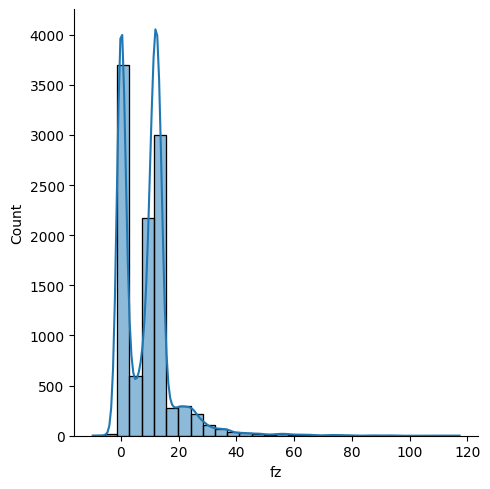

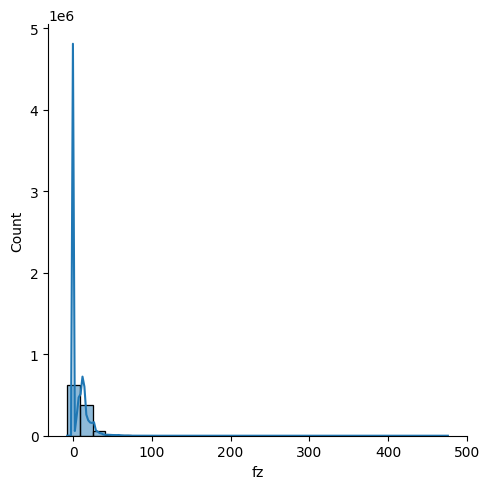

In [12]:
plt.figure()
sns.displot(df[df['case']==1].fz, bins = 30, kde = True)
sns.displot(df[df['case']==0].fz, bins = 30, kde = True)
plt.show()

In [14]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx', 'ry', 'rz',
       'vx', 'vy', 'vz', 'fx', 'fy', 'fz', 'mx', 'my', 'mz', 'case'],
      dtype='object')

In [15]:
# get rid of time/ t_contact and plot correlation matrix
# temp = df.drop(['time','t_contact','z'], axis=1)
temp = df.drop(['Unnamed: 0.1','Unnamed: 0','z','t'], axis=1)

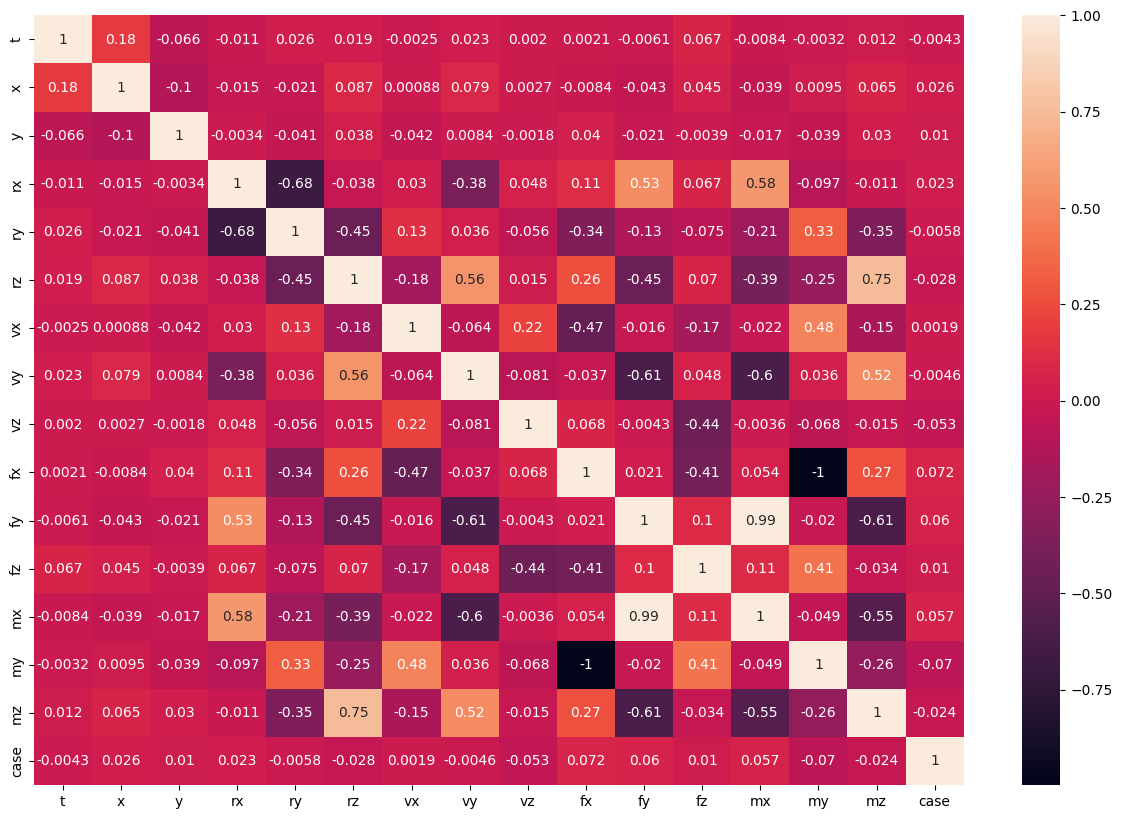

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(temp.corr(),annot=True)
plt.show()

<AxesSubplot:xlabel='Case', ylabel='count'>

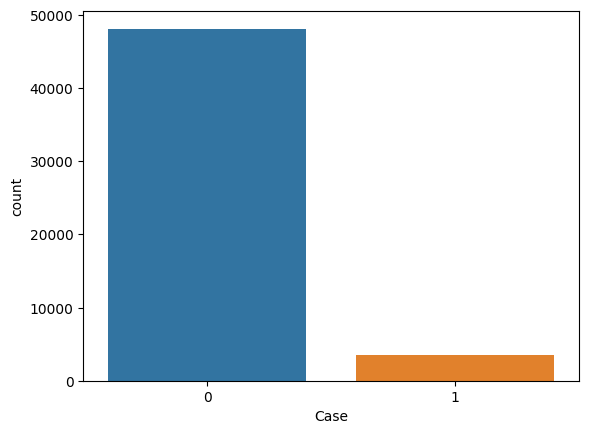

In [11]:
plt.figure()
sns.countplot(x=df['Case'])

In [19]:
# ['time', 'Fx', 'Fy', 'Fz', 'Vx', 'Vy', 'Mx', 'My', 'Case', 't_contact']
# feature_names = ['Fz', 'Mx', 'My']
feature_names = ['fz', 'mx', 'my']
X_df = df[feature_names]
X = X_df.to_numpy()
y = df.case.to_numpy()

window_len = 100

if window_len:
    n_features = len(feature_names)  # 3

    row = X.shape[0] + 1 - window_len
    col_len = n_features * window_len
    new_x = np.zeros((row, col_len))
    new_y = np.zeros((row, 1))

    for i in range(len(new_x)):
        new_x[i] = X[i:i + window_len].reshape(1, col_len)[0][::-1]
        new_y[i] = y[i + (window_len - 1)]

    y = deepcopy(new_y)
    X = deepcopy(new_x)

total = len(y)
pos = int(y.sum())
neg = total - pos
weight = neg/pos # 13.5

In [20]:
X_df.describe()
# MinMaxScaler() - we might look into rescalling in the future?

,fz,mx,my
count,1.077120e+06,1.077120e+06,1.077120e+06
mean,8.015203e+00,6.538537e-02,2.494696e-01
std,1.000187e+01,1.548977e+00,1.589529e+00
min,-9.711754e+00,-3.225147e+01,-2.946983e+01
25%,6.534762e-02,-5.701608e-02,-2.806527e-02
50%,5.343658e+00,5.847109e-04,-3.463634e-04
75%,1.326685e+01,2.542100e-01,6.002114e-01
max,4.758861e+02,3.737520e+01,5.212545e+01


In [21]:
print(f"Total Dataset size: {X.shape}")
print(f"Ratio of 1's in dataset {(pos/total) * 100}% and count is: {pos}")
print(f"Ratio of 0's in dataset {(neg/total) * 100}% and count is: {neg}")

Total Dataset size: (1077021, 300)
Ratio of 1's in dataset 0.9840105253286612% and count is: 10598
Ratio of 0's in dataset 99.01598947467134% and count is: 1066423


### Helper Functions for later

In [22]:
def xgb_stratified_kfold_cross_val(X, y, model, print_info):
    """
    StratifiedKFold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    aucpr_scores = []
    roc_scores = []
    prec_scores =  []
    recall_scores = []
    

    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold_id}:")
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if print_info:
            print(f"Ratio of 1's in train set {np.round((y_train.sum())/len(y_train),4) * 100}%")
            print(f"Ratio of 1's in validation set {np.round((y_valid.sum()/len(y_valid)),4) * 100}%")

        # fit model
        model.fit(
            X_train,
            y_train,
            early_stopping_rounds=15,
            eval_metric='aucpr', #auc
            eval_set=[(X_valid, y_valid)],
            verbose=False)
        
        y_val_pred = model.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_val_pred)
        aucpr = average_precision_score(y_valid, y_val_pred)
        prec = precision_score(y_valid, y_val_pred > 0.5)
        recall = recall_score(y_valid, y_val_pred > 0.5)
        if print_info:
            print('--------------------------------------')
            print(f"Aucpr score for fold {fold_id} is : {aucpr}")
            print(f"ROC score for fold {fold_id} is : {roc}")
            print(f"Precision  : {prec}")
            print(f"Recall : {recall}")
            print('--------------------------------------')

        aucpr_scores.append(aucpr)
        roc_scores.append(roc)
        prec_scores.append(prec)
        recall_scores.append(recall)

    print()
    print(f"Mean across all folds:\nAUCPR: {np.mean(aucpr_scores)}\nROC {np.mean(roc_scores)}\nPrecision: {np.mean(prec_scores)}\nRecall: {np.mean(recall_scores)}")


In [23]:
def get_scores_thresholds(X_test, y_test, model, algo=None):
    thresholds = {0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9}
    for thresh in thresholds:
        if algo == "XGB":
            y_pred = model.predict_proba(X_test)[:, 1]
        else:
            y_pred = model.predict(X_test)
            
        print('threshold:', thresh)
        print(confusion_matrix(y_test, y_pred > thresh))
        print(classification_report(y_test, y_pred > thresh))
        print('--------------------------------------')

In [24]:

def plot_prc_and_roc(y_true, y_pred):

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=1.0, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.1, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid()

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
              average_precision))
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
            Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [25]:
def plot_precision_recall_vs_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_vec = 2 * (precisions * recalls) / (precisions + recalls)
    plt.figure()
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.plot(thresholds, f1_vec[:-1], "k-", label='F1')
    plt.xlabel('Threshold')
    plt.title('Precision/ Recall/ F1 Score/ Threshold')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
def dnn_stratified_kfold_cross_val(X, y, epoch, batch_size, callback, print_info, metrics):
    """
    StratifiedKFold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    aucpr_scores = []
    roc_scores = []
    prec_scores =  []
    recall_scores = []

    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold_id}:")
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if print_info:
            print(f"Ratio of 1's in train set {np.round((y_train.sum())/len(y_train),4) * 100}%")
            print(f"Ratio of 1's in validation set {np.round((y_valid.sum()/len(y_valid)),4) * 100}%")
        
        n_inputs = X_train.shape[1]  
        # make model
        model = make_model(n_inputs, metrics=metrics)
        # fit model
        model_history = model.fit(X_train, y_train,
                          validation_data = (X_valid, y_valid),
                          epochs=epoch,
                          batch_size=batch_size,
                          verbose=0, # 1 
                          callbacks=[callback],
                          shuffle=True) 
        
        y_val_pred = model.predict(X_valid)
        roc = roc_auc_score(y_valid, y_val_pred)
        aucpr = average_precision_score(y_valid, y_val_pred)
        prec = precision_score(y_valid, y_val_pred > 0.5)
        recall = recall_score(y_valid, y_val_pred > 0.5)
        if print_info:
            print('--------------------------------------')
            print(f"Aucpr score for fold {fold_id} is : {aucpr}")
            print(f"ROC score for fold {fold_id} is : {roc}")
            print(f"Precision  : {prec}")
            print(f"Recall : {recall}")
            print('--------------------------------------')

        aucpr_scores.append(aucpr)
        roc_scores.append(roc)
        prec_scores.append(prec)
        recall_scores.append(recall)


    print()
    print(f"Mean across all folds:\nAUCPR: {np.mean(aucpr_scores)}\nROC {np.mean(roc_scores)}\nPrecision: {np.mean(prec_scores)}\nRecall: {np.mean(recall_scores)}")


## 1. Using DNN 


#### Define a model

In [27]:
def make_model(n_inputs, metrics="AUC", output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    nn = keras.Sequential()
    nn.add(keras.layers.Dense(16, input_shape=(n_inputs,), activation='relu'))
    nn.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

    nn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=METRICS)
    # metrics simply tell us what we will be able to see in the log and on plot
    # they do are NOT used for optimization!

    
    return nn

In [28]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', # validation precision 
    mode='max', # specify whether we seek to min/max given metrics
    verbose=1,  # print training epoch on which we stopped
    patience=20, #after how many epochs of no improvement do we stop
    restore_best_weights=True)

In [29]:
# define metrics
# metrics simply tell us what we will be able to see in the log and on plot
# they do are NOT used for optimization!

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2023-01-22 14:31:40.336994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-01-22 14:31:40.337008: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-22 14:31:40.337016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-System-Product-Name): /proc/driver/nvidia/version does not exist
2023-01-22 14:31:40.337140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow wi

### Choosing best hyperparams

In [30]:
n_inputs = X.shape[1]  
print('Input shape',n_inputs)
# define params
EPOCHS=200 # high+ early stopping
BATCH_SIZE=1024

Input shape 300


In [24]:

# create and compile network
dnn = make_model(n_inputs, metrics=METRICS)
batch_size_list = [32, 64, 128, 512, 1024]
for bs in batch_size_list:
# perform statified k fold validation
    print('Batch Size', bs)
    dnn_stratified_kfold_cross_val(X, y,epoch=EPOCHS, batch_size=bs,
                                   callback=early_stopping, print_info=False, metrics=METRICS)

Batch Size 32
Fold 0:
Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
162/162 [==============================] - 0s 317us/step
Fold 1:
Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping
162/162 [==============================] - 0s 270us/step
Fold 2:
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early stopping
162/162 [==============================] - 0s 489us/step
Fold 3:
Restoring model weights from the end of the best epoch: 23.
Epoch 43: early stopping
162/162 [==============================] - 0s 377us/step
Fold 4:
Restoring model weights from the end of the best epoch: 37.
Epoch 57: early stopping
162/162 [==============================] - 0s 276us/step
Fold 5:
Restoring model weights from the end of the best epoch: 42.
Epoch 62: early stopping
162/162 [==============================] - 0s 255us/step
Fold 6:
Restoring model weights from the end of the best epoch: 14.
Epoch 34: early sto

### I chose the best network based on my requirements 
In my case I will focus on the **AUPRC** as my main matrics as well as the value of **Precision**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [33]:
def make_model(n_inputs, metrics="AUC", output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    nn = keras.Sequential()
    nn.add(keras.layers.Dense(16, input_shape=(n_inputs,), activation='relu'))
#     nn.add(keras.layers.Dropout(0.1))
    nn.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

    nn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=METRICS)
    # metrics simply tell us what we will be able to see in the log and on plot
    # they do are NOT used for optimization!

    
    return nn

In [34]:
n_inputs = X_train.shape[1]  # (77862, 3)
print('Input shape',n_inputs)
model = make_model(n_inputs, metrics=METRICS)
print(model.summary())

Input shape 300
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                4816      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________
None


* TruePositives(name='tp'),
* FalsePositives(name='fp')
* TrueNegatives(name='tn'),
* FalseNegatives(name='fn'),
* Precision(name='precision'),
* Recall(name='recall'),
* AUC(name='auc'),
* AUC(name='prc', curve='PR'),

In [35]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', # validation precision 
    mode='max', # specify whether we seek to min/max given metrics
    verbose=1,  # print training epoch on which we stopped
    patience=20, #after how many epochs of no improvement do we stop
    restore_best_weights=True)

In [36]:
EPOCHS=200#50
BATCH_SIZE=128#1024#1024
# train the chosen model
model_history = model.fit(X_train, y_train,
                          validation_data = (X_test, y_test),
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=0,
                          callbacks=[early_stopping],
                          shuffle=True) 

Restoring model weights from the end of the best epoch: 86.
Epoch 106: early stopping


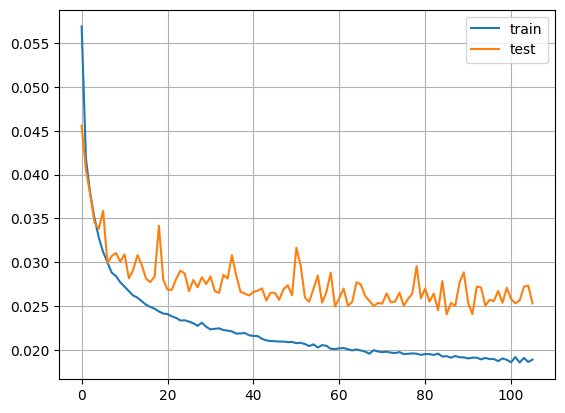

In [37]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

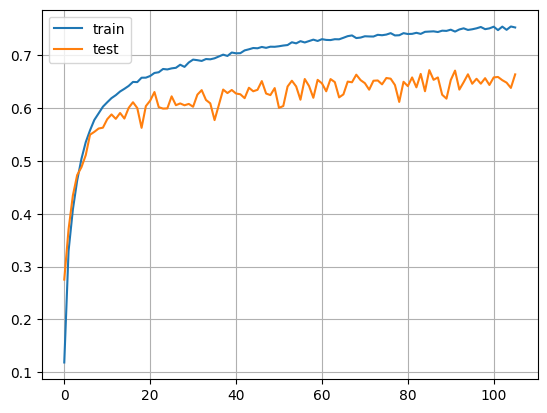

In [38]:
# plot training history
plt.plot(model_history.history['prc'], label='train')
plt.plot(model_history.history['val_prc'], label='test')
plt.legend()
plt.grid()
plt.show()

### Here we should tune the parameters and try different structures.

I will check the results I got so far on the current model

In [39]:
y_test_pred = model.predict(X_test)

6732/6732 [==============================] - 2s 254us/step


In [40]:
print('AUPRC',average_precision_score(y_test, y_test_pred))
print('AUROC',roc_auc_score(y_test, y_test_pred))

print()
print(confusion_matrix(y_test, y_test_pred > 0.5))

AUPRC 0.6872316454158651
AUROC 0.9598053726942557

[[212831    454]
 [   898   1222]]


In [41]:
print(classification_report(y_test, y_test_pred > 0.5))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    213285
         1.0       0.73      0.58      0.64      2120

    accuracy                           0.99    215405
   macro avg       0.86      0.79      0.82    215405
weighted avg       0.99      0.99      0.99    215405



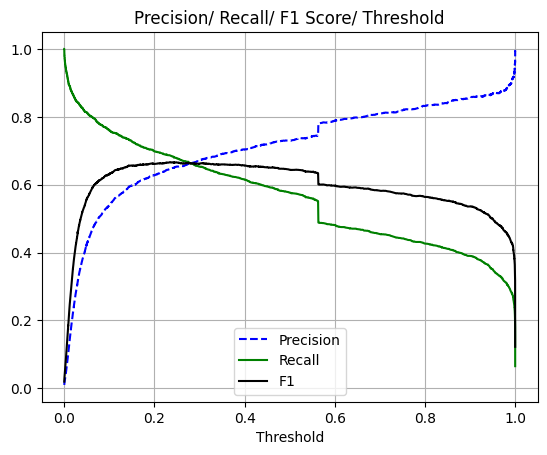

In [42]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

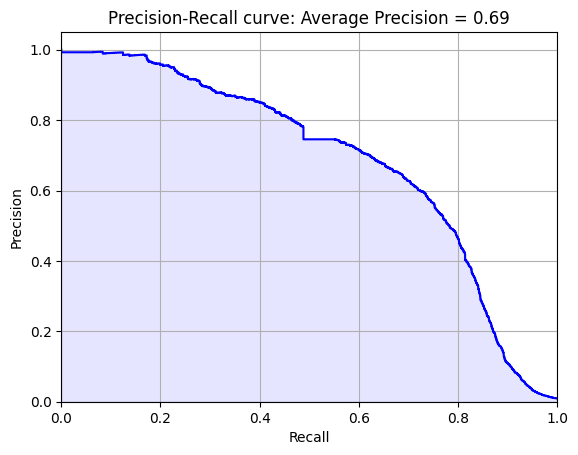

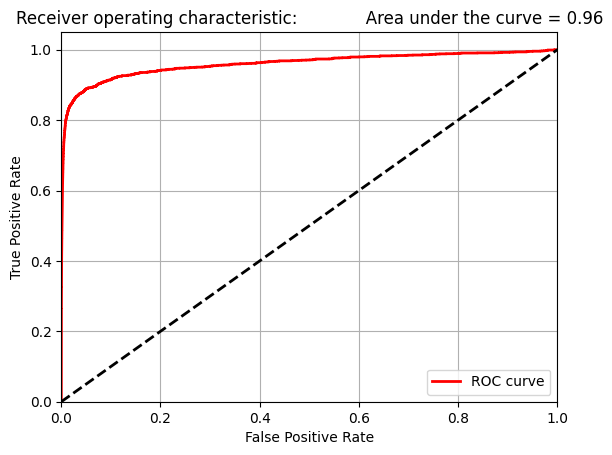

In [43]:
plot_prc_and_roc(y_test, y_test_pred)

In [92]:
get_scores_thresholds(X_test, y_test, model, algo="DNN")

323/323 [==============================] - 0s 357us/step
threshold: 0.1
[[9561   45]
 [  25  688]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9606
         1.0       0.94      0.96      0.95       713

    accuracy                           0.99     10319
   macro avg       0.97      0.98      0.97     10319
weighted avg       0.99      0.99      0.99     10319

--------------------------------------
323/323 [==============================] - 0s 256us/step
threshold: 0.4
[[9578   28]
 [  50  663]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9606
         1.0       0.96      0.93      0.94       713

    accuracy                           0.99     10319
   macro avg       0.98      0.96      0.97     10319
weighted avg       0.99      0.99      0.99     10319

--------------------------------------
323/323 [==============================] - 0s 287us/step
threshold: 0.

# XGBoost Section

## 1. XGBoost Baseline

In [95]:
clf_xgb = XGBClassifier(max_depth = 8,
                         learning_rate = 0.005,
                         n_estimators = 10000,
                         objective = 'binary:logistic',
                         gamma = 0.64,
                         max_delta_step = 3,
                         min_child_weight = 7,
                         subsample = 0.7,
                         colsample_bytree = 0.8,
                         n_jobs = -1)



xgb_stratified_kfold_cross_val(X, y, clf_xgb, print_info=False)

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:

Mean across all folds:
AUCPR: 0.9842586002240878
ROC 0.9986373852735358
Precision: 0.9579735423616071
Recall: 0.8973798508167313


### We take model based on the parameters we got (GridSearchCv)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print('\nAfter split')
print(f"Ratio of 1's in train set {(y_train.sum())/len(y_train) * 100}")
print(f"Ratio of 1's in test set {(y_test.sum()/len(y_test)) * 100}")


After split
Ratio of 1's in train set 6.912676875363442
Ratio of 1's in test set 6.909584262040895


In [97]:
clf_xgb.fit(
            X_train,
            y_train,
            early_stopping_rounds=15,
            eval_metric='aucpr', #auc
            eval_set=[(X_test, y_test)],
            verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.64, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [100]:
y_test_pred = clf_xgb.predict_proba(X_test)[:, 1]

In [101]:
print('AUPRC',average_precision_score(y_test, y_test_pred))
print('AUROC',roc_auc_score(y_test, y_test_pred))

print()
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()
print(classification_report(y_test, y_test_pred > 0.5))

AUPRC 0.9956003660474111
AUROC 0.999620094850723

[[9593   13]
 [  29  684]]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9606
         1.0       0.98      0.96      0.97       713

    accuracy                           1.00     10319
   macro avg       0.99      0.98      0.98     10319
weighted avg       1.00      1.00      1.00     10319



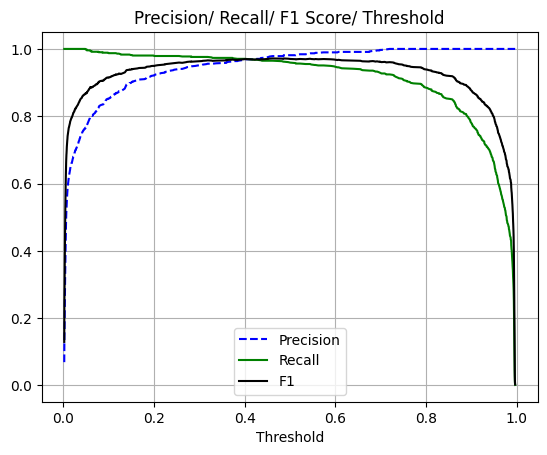

In [104]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

Now we will test the model depending on different decission thresholds. Default is **0.5**

In [107]:
get_scores_thresholds(X_test, y_test, clf_xgb, algo="XGB")

threshold: 0.1
[[9485  121]
 [   9  704]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9606
         1.0       0.85      0.99      0.92       713

    accuracy                           0.99     10319
   macro avg       0.93      0.99      0.95     10319
weighted avg       0.99      0.99      0.99     10319

--------------------------------------
threshold: 0.4
[[9584   22]
 [  21  692]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9606
         1.0       0.97      0.97      0.97       713

    accuracy                           1.00     10319
   macro avg       0.98      0.98      0.98     10319
weighted avg       1.00      1.00      1.00     10319

--------------------------------------
threshold: 0.2
[[9546   60]
 [  15  698]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9606
         1.0       0.92      0.98

In [108]:
# Plotting feature importance
clf_xgb.get_booster().feature_names = X_df.columns.tolist()
importances = clf_xgb.feature_importances_
xgboost.plot_importance(clf_xgb.get_booster())
plt.show()

XGBoostError: [12:46:22] ../src/c_api/c_api_utils.h:230: Check failed: feature_names.size() == n_features (3 vs. 300) : Incorrect number of feature names.
Stack trace:
  [bt] (0) /home/user/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x128d29) [0x7f69ba328d29]
  [bt] (1) /home/user/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15933b) [0x7f69ba35933b]
  [bt] (2) /home/user/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterFeatureScore+0x70a) [0x7f69ba33624a]
  [bt] (3) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f6a74959e2e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f6a74956493]
  [bt] (5) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa451) [0x7f6a74979451]
  [bt] (6) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a68) [0x7f6a74978a68]
  [bt] (7) /usr/bin/python3(_PyObject_MakeTpCall+0x25b) [0x5621a3f4f7db]
  [bt] (8) /usr/bin/python3(_PyEval_EvalFrameDefault+0x6b4e) [0x5621a3f4848e]



In [ ]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

In [ ]:
plot_prc_and_roc(y_test, y_test_pred)

## 2. Hyperparameter Tunning

### 2.1 Bayesian optimisation
Bayesian optimisation in turn takes into account past evaluations when choosing the hyperparameter set to evaluate next. By choosing its parameter combinations in an informed way, it enables itself to focus on those areas of the parameter space that it believes will bring the most promising validation scores. This approach typically requires less iterations to get to the optimal set of hyperparameter values. Most notably because it disregards those areas of the parameter space that it believes won’t bring anything to the table.

### TBD

In [ ]:
# we wont use balancing tools as they seem to increase FP in expensive of increasing FN, 
# which is the opposite of what we want
param_grid = {
    'n_estimators': [200, 300, 500, 1000],
    'max_depth': [2, 4, 6, 8], # 2-8
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1], # 0.1 or lower, smaller values will require more trees
    'gamma': [0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 5.0, 10.0]}}

# for imbalanced
# {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'reg_lambda': 5.0}
param_grid = {
    'n_estimators': [300],
    'max_depth': [8], # 2-8
    'learning_rate': [0.1], # 0.1 or lower, smaller values will require more trees
    'gamma': [0.25],
    'reg_lambda': [5.0]}
    # 'scale_pos_weight': [10]  # use neg/pos
# }
# we only use subset of data 90%, and use subset of features 50% per tree
# optim_params = GridSearchCV(
#     estimator= XGBClassifier(objective='binary:logistic',
#                              seed=42,
#                              subsample=0.9,
#                              colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     verbose=2,
#     n_jobs=-1,
#     cv=5
# )
#
# optim_params.fit(
#     X_train,
#     y_train,
#     early_stopping_rounds=10,
#     eval_metric='aucpr',
#     eval_set=[(X_test, y_test)],
#     verbose=False
# )
# print(optim_params.best_params_)


# 3. Building Model using optimal parameters
clf_xgb = XGBClassifier(seed=42,
                        objective='binary:logistic',
                        n_estimators=300,
                        gamma=0.25,
                        learning_rate=0.2,
                        max_depth=8,
                        reg_lambda=10.0,
                        subsample=0.9,
                        colsample_bytree=0.5)
# scale_pos_weight=10,

clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['No overlap (0)', 'Overlap (1)'])
plt.show()


plot_importance(clf_xgb)
plt.show()



#
#
#
#
# # Stratified sampling aims at splitting a data set so that each split is similar with respect to something.
# sss = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
#
# # we keep X_train/ test and y_train/test for the under sampled data
# X_train, X_test, y_train, y_test = None, None, None, None
#
# for train_index, test_index in sss.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#
# total = len(y_train)
# pos = y_train.sum()
# neg = total - pos
#
# # we set split_num=5 -> 25% for test, 75 train
# print('Train length', len(X_train))
# print('Test length', len(X_test))
# print(f'{len(X_test) / len(X_train) * 100}% of the data is testing')
# print()
# print(f"Ratio of 1 in train {y_train.sum() / len(y_train) * 100} ")
# print(f"Ratio of 1 in test {y_test.sum() / len(y_test) * 100}")
#
# '''We have same distribution of labels in train and test data!'''
#
# print('Dumb classifier accuracy', (1 - y_test.sum() / len(y_test)) * 100)
#
# print(f'Train set size {len(y_train)}')
# print("Number of labels '1' in training set: {}".format(y_train.sum()))
# print("Number of labels '0' in training set: {} \n".format(len(y_test) - y_train.sum()))
#
# # model = XGBClassifier(scale_pos_weight=weight)
# #  0.99009 vs 0.99031 with weight: not worth it
# # TODO: baseline!!!!
# # define evaluation procedure
# # https://stackoverflow.com/questions/71181291/differences-between-repeatedstratifiedkfold-and-stratifiedkfold-in-sklearn
# # using the early stopping instead of cross validation
#
# # add penalty for incorrectly classifing the minority class
#
#
# '''Run the default configuration and review plots of the learning curves on the training and validation datasets.
#     If the system is overlearning, decrease the learning rate and/or increase the number of trees.
#     If the system is underlearning, speed the learning up to be more aggressive by increasing the learning rate and/or decreasing the number of trees.'''
#
#
# '''He suggests to set the number of trees to a target value such as 100 or 1000,
# then tune the learning rate to find the best model. This is an efficient strategy for quickly finding a good model'''
# # from sklearn.preprocessing import LabelEncoder
# # le = LabelEncoder()
# # y_train = le.fit_transform(y_train)
#
# # TODO: stacking: use one models output as input to the other
# # weight = int(neg / pos)
# # clf_xgb = XGBClassifier(objective='binary:logistic', seed=42, scale_pos_weight=weight)
# clf_xgb = XGBClassifier(objective='binary:logistic')
# clf_xgb.fit(X_train,
#             y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric='aucpr',
#             eval_set=[(X_test, y_test)])
#
#
#
# while True:
#     t_init = time.time()
#     a = np.array([1, 2, 3, 4,5, 6, 7,8,9]).reshape(1, 9)
#     b= clf_xgb.predict_proba(a)
#     print(b)
#     print('dt', time.time()-t_init)
#
# t=False
# if t:
#     plt.figure()
#     plot_confusion_matrix(clf_xgb,
#                           X_test,
#                           y_test,
#                           values_format='d',
#                           display_labels=['Not Switch', 'Switch'])
#     plt.show()
#
#     # print('Classification Report for: Original TRAIN SET')
#     # print(classification_report(original_y_train, train_pred_ori > 0.5))
#
#     # TODO: optimize parameters using cross validation and gridSearch()
#
#     # when data is imbalanced used: balance using scale_pos_weight and use AUC for eval
#     # round1 1
#     param_grid = {
#         'n_estimators': [50, 100, 150, 200],
#         'max_depth': [3, 4, 5], # 2-8
#         'learning_rate': [0.01, 0.05, 0.1], # 0.1 or lower, smaller values will require more trees
#         'gamma': [0, 0.25, 1.0],
#         'reg_lambda': [0, 1.0, 10.0],
#         'scale_pos_weight': [1, 3, 5]  # use neg/pos
#     }
#
#     # do second batch and optimize
#     # to speed up cross-val and percent over-fitting we are using  random subset of the data (90%)
#     # and are using random subset of features (columns) (50%) per tree
#     # https://xgboost.readthedocs.io/en/stable/parameter.html
#     # TODO stratified k fold valiadtion!!!!!!
#     """kfold = StratifiedKFold(n_splits=10, random_state=7)
#     results = cross_val_score(model, X, Y, cv=kfold)"""
#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
#     optimal_params = GridSearchCV(
#         estimator=XGBClassifier(objective='binary:logistic',
#                                 seed=42,
#                                 subsample=0.9, # 30-80
#                                 colsample_bytree=0.5),
#         param_grid=param_grid,
#         scoring='roc_auc',
#         verbose=2,
#         n_jobs=-1,
#         cv=kfold# 3  # change to 10 in final model!
#     )
#
#     # aucpr?????
#     optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])
#     print("Best: %f using %s" % (optimal_params.best_score_, optimal_params.best_params_))
#     # after obtaining the optimal params we can finally do the optimized params
#     # clf_xgb = XGBClassifier(objective='binary:logistic', seed=42, scale_pos_weight=weight, ......)
#     # clf_xgb.fit(X_train,
#     #             X_test,
#     #             verbose=True,
#     #             early_stopping_rounds=10,
#     #             eval_metric='aucpr',
#     #             eval_set=[(X_test, y_test)])
#     # plot confusion matrix
#     # TODO: feature importance
#     # These importance scores can help you decide what input variables to keep or discard.
#     # They can also be used as the basis for automatic feature selection techniques.
#     # # plot feature importance using built-in function
#     # model.fit(X, y)
#     plot_importance(clf_xgb)
#     plt.show()
#
#     # TODO: fit final model on all of the data
#
